In [93]:
import numpy as np
import pandas as pd
from pathlib import Path
from colors import strip_color
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import array
import math
from scipy.stats import norm

%matplotlib inline 

sns.set_style("whitegrid")
sns.set_palette("Blues")

In [94]:
LOG_PATH = Path('./log/')
DATA_PATH = Path('./data/')

In [95]:
def get_files(extension, committee_size, latency, minerblocksize, long=True):
    log_folder = '%s_%d_%d_%d' % (extension, committee_size, latency, minerblocksize)
    if long == True:
        log_folder += '_long'
    data_path = LOG_PATH / log_folder
    log_files = [x for x in data_path.iterdir() if x.name.endswith('.log')]
    dstat_files = [x for x in data_path.iterdir() if x.name.endswith('.csv')]
    return log_files, dstat_files

In [96]:
def _sanitize(s):
    s = strip_color(s)
    s = s.strip('[1;38;5;8m')
    s = s.strip('\n')
    return s

def _get_time(s):
    dt_str = s[0:23]
    return datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f')

def get_blocks(log_file):
    blocks = dict()
    for line in open(log_file.absolute()):
        block = dict()
        line = _sanitize(line)
        if line.find('Block submitted via CPU miner accepted') != -1: # mined a block
            blockhash = line.split(' ')[-4].strip(',')
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'mined_time' not in blocks[blockhash]:
                blocks[blockhash]['mined_time'] = _get_time(line)
#         if line.find('PEER: Received block (hash') != -1: # received a block
#             blockhash = line.split(' ')[7].strip(',')
        if line.find('SYNC: received block') != -1: # received a block
            blockhash = line.split(' ')[6].strip(',')
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'received_time' not in blocks[blockhash]:
                blocks[blockhash]['received_time'] = _get_time(line)
        if line.find('has been finalised') != -1: # finalised
            blockhash = line.split(' ')[-4]
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'finalised_time' not in blocks[blockhash]:
                blocks[blockhash]['finalised_time'] = _get_time(line)
    
    blockhash_to_remove = list()
    for blockhash in blocks.keys():
        if 'finalised_time' not in blocks[blockhash] or len(blocks[blockhash]) < 2:
            blockhash_to_remove.append(blockhash)
            continue
        
        if 'mined_time' in blocks[blockhash].keys(): # this block is mined by this miner
            blocks[blockhash]['time_to_finalise'] = blocks[blockhash]['finalised_time'] - blocks[blockhash]['mined_time']
        elif 'received_time' in blocks[blockhash].keys(): # this block is mined by other miners
            blocks[blockhash]['time_to_finalise'] = blocks[blockhash]['finalised_time'] - blocks[blockhash]['received_time']
    
    for blockhash in blockhash_to_remove:
        del blocks[blockhash]
    
    return blocks

# TODO (RH) rerun psyncorazor_64_5_{20,40}_long
# lfiles, dfiles = get_files('syncorazor', 64, 5, 10, long=True)
# blocks = get_blocks(lfiles[3])
# for blockhash in blocks.keys():
#     print(blocks[blockhash])

## Block propagation/finalisation delay

In [183]:
def get_finalisation_latency_stats(extension, committee_size, latency, minerblocksize):
    # dict{block: [gap1, gap2, ...]}
    delay_dict = dict()
    lfiles, _ = get_files(extension, committee_size, latency, minerblocksize)
    for lf in lfiles:
        blocks = get_blocks(lf)
        for blockhash, block in blocks.items():
            if blockhash not in delay_dict.keys():
                delay_dict[blockhash] = list()
            delay_dict[blockhash].append(block['time_to_finalise'])
    
    all_delays = []
    for block, delays in delay_dict.items():
        for delay in delays:
            all_delays.append(delay.seconds*1000 + delay.microseconds/1000)
    
    all_delays_array = np.array(all_delays)
    return all_delays_array.mean(), all_delays_array.std()

def save_latency_stats(extensions, committee_sizes, latencies, minerblocksizes):
    df = pd.DataFrame()
    for extension in extensions:
        for committee_size in committee_sizes:
            for latency in latencies:
                for minerblocksize in minerblocksizes:
                    mean, std = get_finalisation_latency_stats(extension, committee_size, latency, minerblocksize)
                    line = {
                        'extension': extension, 
                        'committee_size': committee_size, 
                        'latency': latency, 
                        'minerblocksize': minerblocksize, 
                        'mean': mean, 
                        'std': std
                    }
                    df = df.append(line, ignore_index=True)
    df.to_csv(DATA_PATH / 'latency.csv')
    return df

latency_df = save_latency_stats(['syncorazor', 'psyncorazor'], [4,8,16,32,64,128], [5], [10,20,40,60])
# latency_df

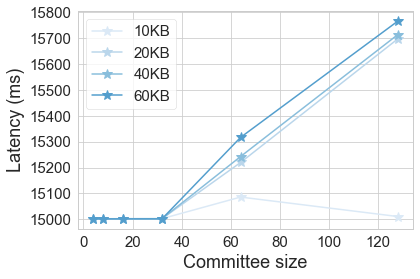

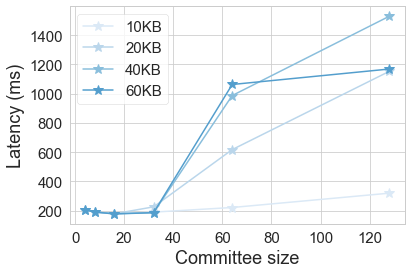

In [184]:
extensions = ['syncorazor', 'psyncorazor']
committee_sizes = [4,8,16,32,64,128]
latency = 5
minerblocksizes = [10, 20, 40, 60]

def plot_latency(df, extension, committee_sizes, minerblocksizes):
    plt.figure()

    for minerblocksize in minerblocksizes:
        lines = df[(df['extension']==extension) & (df['committee_size'].isin(committee_sizes)) & (df['latency']==latency) & (df['minerblocksize']==minerblocksize)]
        delay_means = lines['mean']
        delay_stds = lines['std']
#         plt.errorbar(committee_sizes, delay_means, yerr=delay_stds, label="%dKB" % minerblocksize)
        plt.plot(committee_sizes, delay_means, '-*', label="%dKB" % minerblocksize, markersize=10)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Committee size', fontsize=18)
    plt.ylabel('Latency (ms)', fontsize=18)
    plt.legend(fontsize=15)
    plt.show()

# redo
# sync 64 10
plot_latency(latency_df, 'syncorazor', [4,8,16,32,64,128], [10,20,40,60])
plot_latency(latency_df, 'psyncorazor', [4,8,16,32,64,128], [10,20,40,60])

# plot_latency(latency_df, 'syncorazor', [4,8,16,32,64,128], [10])
# plot_latency(latency_df, 'syncorazor', [4,8,16,32,64,128], [20])
# plot_latency(latency_df, 'syncorazor', [4,8,16,32,64,128], [40])
# plot_latency(latency_df, 'syncorazor', [4,8,16,32,64,128], [60])

# plot_latency(latency_df, 'psyncorazor', [4,8,16,32,64,128], [10])
# plot_latency(latency_df, 'psyncorazor', [4,8,16,32,64,128], [20])
# plot_latency(latency_df, 'psyncorazor', [4,8,16,32,64,128], [40])
# plot_latency(latency_df, 'psyncorazor', [4,8,16,32,64,128], [60])

## Network bandwidth utilisation

In [177]:
def get_bw_util(extension, committee_size, latency, minerblocksize):
    _, dfiles = get_files(extension, committee_size, latency, minerblocksize)
    recvs, sends = [], []
    for dfile in dfiles:
        df = pd.read_csv(dfile.absolute(), skiprows=6)
        recvs.append(df['recv'].mean())
        sends.append(df['send'].mean())
    return np.array(recvs).mean(), np.array(sends).mean() # all in Bytes

def save_bw_util(extensions, committee_sizes, latencies, minerblocksizes):
    df = pd.DataFrame()
    for extension in extensions:
        for committee_size in committee_sizes:
            for latency in latencies:
                for minerblocksize in minerblocksizes:
                    recv, send = get_bw_util(extension, committee_size, latency, minerblocksize)
                    line = {
                        'extension': extension, 
                        'committee_size': committee_size, 
                        'latency': latency, 
                        'minerblocksize': minerblocksize, 
                        'recv': recv, 
                        'send': send
                    }
                    df = df.append(line, ignore_index=True)
    df.to_csv(DATA_PATH / 'bw_util.csv')
    return df

bw_df = save_bw_util(['syncorazor', 'psyncorazor'], [4,8,16,32,64,128], [5], [10,20,40,60])
# bw_df

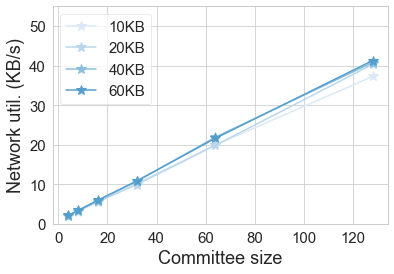

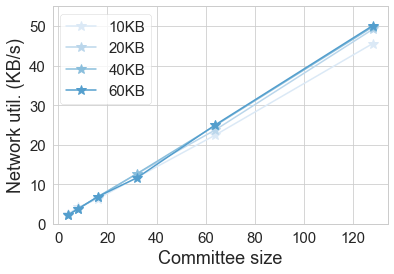

In [178]:
def plot_bw_util(df, extension, committee_sizes, minerblocksizes):
    plt.figure()

    for minerblocksize in minerblocksizes:
        lines = df[(df['extension']==extension) & (df['committee_size'].isin(committee_sizes)) & (df['latency']==latency) & (df['minerblocksize']==minerblocksize)]
        recvs = lines['recv']
        sends = lines['send']
        total_utils = (recvs+sends)/1000
        plt.plot(committee_sizes, total_utils, '-*', label="%dKB" % minerblocksize, markersize=10)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Committee size', fontsize=18)
    plt.ylabel('Network util. (KB/s)', fontsize=18)
    plt.ylim([0, 55])
    plt.legend(fontsize=15)
    plt.show()

plot_bw_util(bw_df, 'syncorazor', [4,8,16,32,64,128], [10,20,40,60])
plot_bw_util(bw_df, 'psyncorazor', [4,8,16,32,64,128], [10,20,40,60])

In [ ]:
# fork rate
# BPD